In [51]:
# coding=utf-8
import cv2
import numpy as np
from numpy import random
import math


class RandomRotation(object):
    def __call__(self, image, keypoints):
        h, w, c = image.shape
        center = (w / 2, h / 2)
        print("RandomRotation---")
        if random.randint(2):
            degree = random.randint(-30, 30)
            w_r = int(w * math.fabs(math.cos(math.radians(degree))) +
                      h * math.fabs(math.sin(math.radians(degree))))
            h_r = int(w * math.fabs(math.sin(math.radians(degree))) +
                      h * math.fabs(math.cos(math.radians(degree))))
            m = cv2.getRotationMatrix2D(center, degree, 1)  # 旋转矩阵
            m[0][2] += (w_r - w) / 2
            m[1][2] += (h_r - h) / 2
            image = cv2.warpAffine(image, m, (w_r, h_r))
            # 计算旋转后的关节点的位置
            kps = np.reshape(keypoints, (-1, 3))[:, 0:2]
            v = np.reshape(keypoints, (-1, 3))[:, 2]
            kps = np.hstack((kps, np.ones(14, dtype=int)[:, np.newaxis]))
            kps = np.dot(kps, m.T).astype('int')
            keypoints = np.hstack((kps, v[:, np.newaxis]))
        return image, keypoints


class RandomMirror(object):  # 实现图片的水平反转flip
    def __call__(self, image, keypoints):
        h, w, c = image.shape

        if random.randint(2):
            image = image[:, ::-1].copy()
            keypoints = keypoints.copy()
            keypoints[:, 0] = w - keypoints[:, 0]
        return image, keypoints


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, keypoints=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            #             image *= alpha
            np.multiply(image, alpha, out=image, casting='unsafe')
        return image, keypoints


class ConvertColor(object):
    """颜色空间转换"""

    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, keypoints=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, keypoints


class RandomBrightness(object):
    """随机增加图片的亮度"""

    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, keypoints=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            #             image += delta
            np.add(image, delta, out=image, casting="unsafe")
        return image, keypoints


class RandomSaturation(object):
    """随机饱和度"""

    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, keypoints=None):
        if random.randint(2):
            #             image[:, :, 1] *= random.uniform(self.lower, self.upper)
            np.multiply(image[:, :, 1], random.uniform(self.lower, self.upper),
                        out=image[:, :, 1], casting="unsafe")

        return image, keypoints


class RandomHue(object):
    """随机色调(色相)"""

    def __init__(self, delta=18.0):
        assert 0.0 <= delta <= 360.0
        self.delta = delta

    def __call__(self, image, keypoints=None):
        if random.randint(2):
            #             image[:, :, 0] += random.uniform(-self.delta, self.delta)
            np.add(image[:, :, 0],
                   random.uniform(-self.delta, self.delta),
                   out=image[:, :, 0], casting="unsafe")
            #             image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            np.subtract(image[:, :, 0][image[:, :, 0] > 360.0], 360.0,
                        out=image[:, :, 0][image[:, :, 0] > 360.0], casting='unsafe')
            #             image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
            np.subtract(image[:, :, 0][image[:, :, 0] < 0.0], 360.0,
                        out=image[:, :, 0][image[:, :, 0] < 0.0], casting='unsafe')
        return image, keypoints


class RandomLightingNoise(object):
    """随机交换图片的通道,也就是随机shuffle channels的顺序"""

    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, keypoints=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, keypoints


class SwapChannels(object):
    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        image = image[:, :, self.swaps]
        return image


class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, keypoints):
        print("photometricdistort---")
        im = image.copy()
        im, keypoints = self.rand_brightness(im, keypoints)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, keypoints = distort(im, keypoints)
        return self.rand_light_noise(im, keypoints)


class Make_padding(object):
    def __call__(self, image):
        h, w, c = image.shape
        if h > w:
            image = np.concatenate((image, np.zeros((h, h - w, 3), dtype=image.dtype)), axis=1)
        elif w > h:
            image = np.concatenate((image, np.zeros((w - h, w, 3), dtype=image.dtype)), axis=0)
        return image


class Resize(object):
    def __init__(self, size=256):
        self.size = size
        self.mp = Make_padding()

    def __call__(self, image, keypoints):
        image = self.mp(image)
        image = cv2.resize(image, (self.size, self.size))
        return image, keypoints


class KeypointTransform(object):
    def __call__(self, image, keypoints):
        h, w, c = image.shape
        print("KeypointTransform---")
        if h > w:
            scale = 256.0 / h
            m = np.array([[scale, 0, 0], [0, scale, 0]])  # 缩放变换矩阵
            keypoints = np.reshape(keypoints.copy(), (-1, 3))
            v = keypoints[:, 2]
            #             keypoints = np.dot(keypoints, m.T)
            keypoints = np.hstack((np.dot(keypoints, m.T), v[:, np.newaxis]))
        else:
            scale = 256.0 / w
            m = np.array([[scale, 0, 0], [0, scale, 0]])  # 缩放变换矩阵
            keypoints = np.reshape(keypoints.copy(), (-1, 3))
            v = keypoints[:, 2]
            keypoints = np.hstack((np.dot(keypoints, m.T), v[:, np.newaxis]))
        return image, keypoints.astype('int')


class GenerateLabel(object):
    def __call__(self, image, keypoints):
        radius = 10
        heatmap_res = None
        x = np.arange(0, 256, dtype=np.uint32)
        y = np.arange(0, 256, dtype=np.uint32)[:, np.newaxis]
        for kp in keypoints:
            if kp[2] == 1:
                if heatmap_res is None:
                    heatmap_res = ((x - kp[0]) ** 2 + (y - kp[1]) ** 2) <= radius ** 2
                else:
                    heatmap_res = np.vstack((heatmap_res, (((x - kp[0]) ** 2 + (y - kp[1]) ** 2) <= radius ** 2)))
            else:
                if heatmap_res is None:
                    heatmap_res = np.zeros((256, 256), dtype=np.uint8)
                else:
                    heatmap_res = np.vstack((heatmap_res, np.zeros((256, 256), dtype=np.uint8)))
        heatmap_res = heatmap_res.astype(np.uint8)

        return image, np.reshape(heatmap_res, (-1, 256, 256))


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, iamge, keypoints):
        for t in self.transforms:
            image, keypoints = t(iamge, keypoints)
        return image, keypoints


class HPEAugmentation(object):
    def __init__(self):
        self.augment = transforms.Compose([
            RandomMirror(),
            PhotometricDistort(),
            RandomRotation(),
            KeypointTransform()
        ])
    def __call__(self, image, keypoints):
#         image, keypoints = self.augment(image, keypoints)
        return self.augment(image, keypoints)
    
class HPETest(object):
    def __init__(self):
        self.rm = RandomMirror()
        self.pd = PhotometricDistort()
        self.rr = RandomRotation()
        self.kt = KeypointTransform()
    def __call__(self, image, keypoints):
        image, keypoints = self.rm(image, keypoints)
        image, keypoints = self.pd(image, keypoints)
        image, keypoints = self.rr(image, keypoints)
        image, keypoints = self.kt(image, keypoints)
        return image, keypoints


In [22]:
from torchvision import transforms

In [3]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def show_landmarks(image, landmarks=None):
    """Show image with landmarks"""
    plt.imshow(image)
    if landmarks is not None:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='o', c='r')
    plt.pause(0.001) 

import pickle
path = '../interim_data/train_preprocessed.pkl'
with open(path, 'rb') as f:
    pro_annos = pickle.load(f)
im_dir='/media/bnrc2/_backup/ai/ai_challenger_keypoint_train_20170902/keypoint_train_images_20170902/'

anno = pro_annos[1]
img = cv2.imread(im_dir + anno['image_id'] + '.jpg')
lx, ly = anno['coords'][:2]
rx, ry = anno['coords'][2:]
img1 = img[ly:ry, lx:rx, :]
plt.imshow(img1)

In [7]:
kps = np.array(anno['keypoints']).reshape(-1, 3)
kps = kps - [95, 171, 0]

photometricdistort---
RandomRotation---
KeypointTransform---


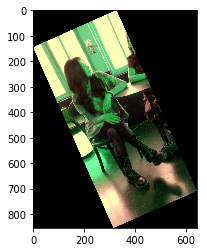

In [59]:
ht = HPETest()
im,kps = ht(img1, kps)
plt.imshow(im)

In [48]:
hpe = HPEAugmentation()
hpeimg, hpekps = hpe(img1, kps)
plt.imshow(hpeimg)

TypeError: __call__() takes 2 positional arguments but 3 were given

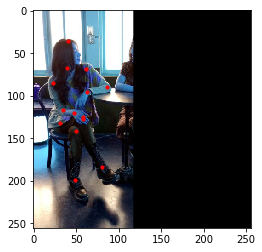

In [11]:
kt = KeypointTransform()
kt_im, kt_kps = kt(img1, kps)

resize = Resize()
r_im, r_kps = resize(kt_im, kt_kps)
plt.figure()
show_landmarks(r_im, r_kps)
plt.show()

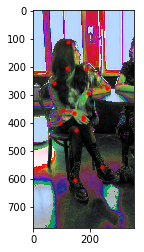

In [17]:
pd = PhotometricDistort()
pd_im, pd_kps = pd(img1, kps)
plt.figure()
show_landmarks(pd_im, pd_kps)
plt.show()